# Analyse BlueSeis BSPF Event - Demo 1

This demonstrates the analysis of two earthquakes, one local M4.1 and one regional M6.2 event for the BSPF station in Southern Califronia.

In [33]:
import os
import obspy as obs
import numpy as np
import matplotlib.pyplot as plt

from obspy import UTCDateTime

from sixdegrees.sixdegrees import sixdegrees
from sixdegrees.plots.plot_velocities import plot_velocities
from sixdegrees.plots.plot_waveform_cc import plot_waveform_cc
from sixdegrees.plots.plot_cwt_all import plot_cwt_all
from sixdegrees.plots.plot_spectra_comparison_fill import plot_spectra_comparison_fill
from sixdegrees.plots.plot_backazimuth_results import plot_backazimuth_results
from sixdegrees.plots.plot_trace_dispersion import plot_trace_dispersion


## Configurations

Set configuration parameters for the event and data in the cell below. We load the data from a prepared mseed file.

In [2]:
config = {
    # Required time window parameters
    'tbeg': "2022-12-31 12:12:20",  # Start time
    'tend': "2022-12-31 12:12:55",  # End time
    
    # Event parameters
    'origin_time': "2022-12-31 12:12:20",
    'magnitude': 4.1,
    
    # Station coordinates (required)
    'station_lon': -116.455439,  # BSPF longitude
    'station_lat': 33.610643,    # BSPF latitude
    
    # SEED identifiers
    'seed': "XX.BSPF..",     # Default seed ID
    'rot_seed': ["XX.BSPF..BJZ", "XX.BSPF..BJN", "XX.BSPF..BJE"],  # Rotation sensor seed ID
    'tra_seed': ["XX.BSPF..BHZ", "XX.BSPF..BHN", "XX.BSPF..BHE"],  # Translation sensor seed ID
    
    # Specify data source
    'data_source': "mseed_file",

    # Specify path to mseed file
    'path_to_mseed_file': "./data/bspf_M4.1_6c.mseed",

    # Path configurations
    'workdir': "./",            # Working directory
    'path_to_data_out': "./output/",  # Output directory

    # Project information
    'project': "BSPF_Analysis",  # Project name

    # Optional parameters
    'verbose': True,            # Print detailed information
}

Initalize a sixdegrees object

In [3]:
sd = sixdegrees(conf=config)

Store the configuration as a pickle file

In [4]:
filename = "./config/"+f"config_BSPF_M{str(config['magnitude'])}_{config['tbeg'][:10].replace('-','')}" 

# sd.store_as_yaml(config, filename)

Get key information about the event

In [5]:
ev = sd.get_event_info(
    base_catalog="USGS",
    origin_time=config['origin_time'],
    magnitude=config['magnitude']
)

Found event:
Origin time: 2022-12-31T12:12:26.650000Z
Magnitude: 4.14 mw
Location: 33.398°N, -116.393°E
Depth: 3.9 km
Epicentral Distance: 24.33 km
Epicentral Distance: 0.2°
Backazimuth: 166.26°


This will load the data from the specified data source:
- local mseed file
- local sds system
- fdsn (online)


Additionally we will resample the data

In [6]:
sd.load_data(config['tbeg'], config['tend'], resample_rate=20)

-> fetching XX.BSPF..BHZ data from mseed file
-> fetching XX.BSPF..BHN data from mseed file
-> fetching XX.BSPF..BHE data from mseed file
3 Trace(s) in Stream:
XX.BSPF..BHZ | 2022-12-31T12:12:19.019538Z - 2022-12-31T12:12:55.969538Z | 20.0 Hz, 740 samples
XX.BSPF..BHN | 2022-12-31T12:12:19.019538Z - 2022-12-31T12:12:55.969538Z | 20.0 Hz, 740 samples
XX.BSPF..BHE | 2022-12-31T12:12:19.019538Z - 2022-12-31T12:12:55.969538Z | 20.0 Hz, 740 samples
-> fetching XX.BSPF..BJZ data from mseed file
-> fetching XX.BSPF..BJN data from mseed file
-> fetching XX.BSPF..BJE data from mseed file
3 Trace(s) in Stream:
XX.BSPF..BJZ | 2022-12-31T12:12:19.003800Z - 2022-12-31T12:12:55.953800Z | 20.0 Hz, 740 samples
XX.BSPF..BJN | 2022-12-31T12:12:19.003800Z - 2022-12-31T12:12:55.953800Z | 20.0 Hz, 740 samples
XX.BSPF..BJE | 2022-12-31T12:12:19.003800Z - 2022-12-31T12:12:55.953800Z | 20.0 Hz, 740 samples
-> resampling stream to 20 Hz
6 Trace(s) in Stream:
XX.BSPF..BHZ | 2022-12-31T12:12:19.019538Z - 2022-12

Ensure that all traces of stream have the same sample size

In [7]:
sd.trim_stream(set_common=True, set_interpolate=False)

Now we can have a look at the waveforms of all 6 components

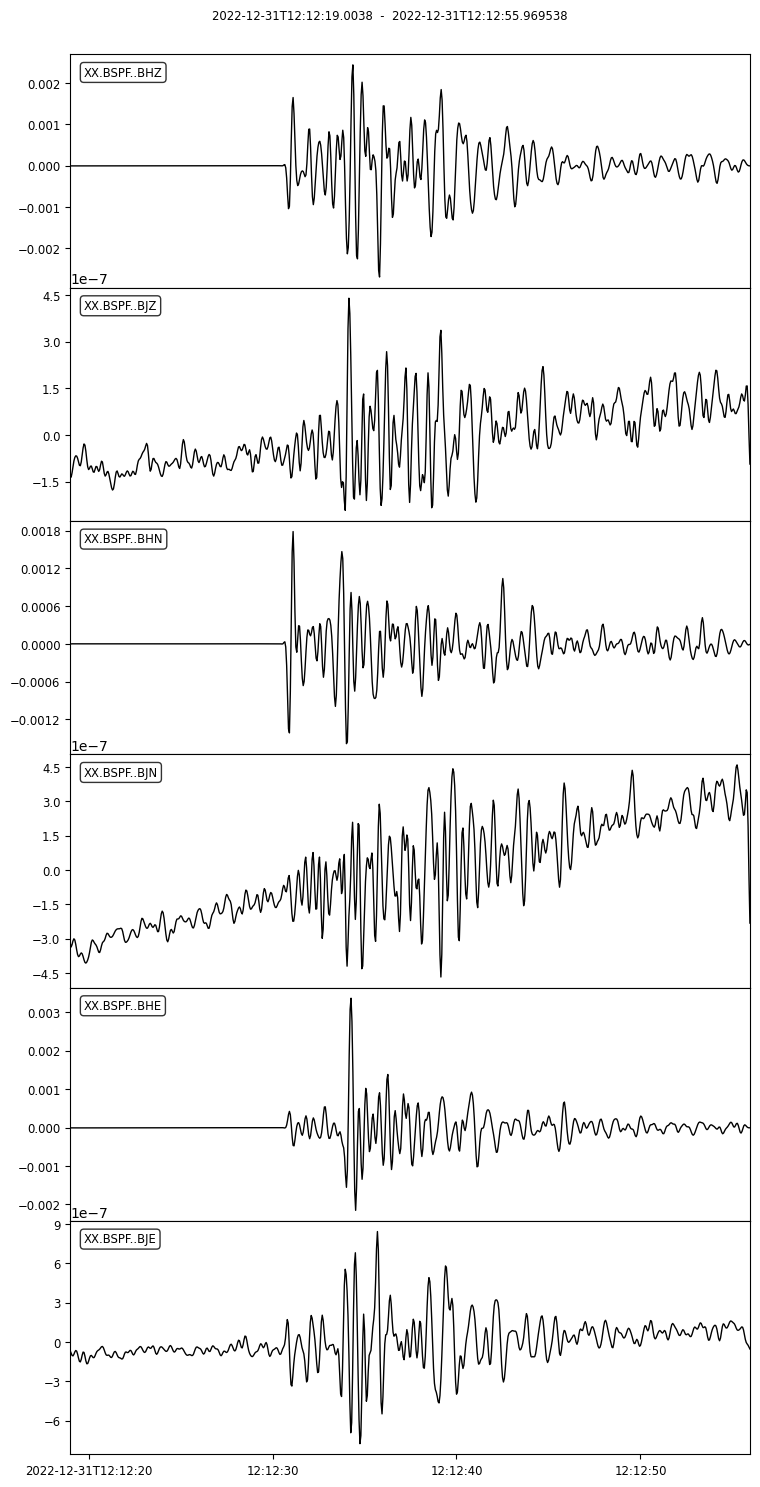

In [8]:
sd.st.plot(equal_scale=False);

### Only required for time lag correction

This computes the time lag between the translation and rotation components based on cross-correlation for transverse and vertical component combinations. If correction is True, the time lag is applied to the rotation component.

In [9]:
#find (and correct) time lag between translation and rotation data
# sd.get_component_lag(
#     normalize=True,
#     baz=ev['backazimuth'],
#     correct=False
# )

# update endtime
# sd.tend = sd.tbeg+25

# trim stream
# sd.st = sd.st.trim(sd.tbeg, sd.tend)

# sd.st.plot(equal_scale=False);

### Write data to file or SDS system

This allows to write the data to a file or the SDS system. For the mseed file the seed id is as specified in the config.

In [10]:
# write to mseed file
# sd.st.write(f"./data/bspf_M{round(ev['magnitude'], 1)}_6c.mseed", format="MSEED")

# write to sds filesystem
# sd.write_to_sds(sd.st, "./data/", format="MSEED")

## Analysis

Set parameters for the analysis below

In [22]:
params = {
    # frequency band
    "fmin": 0.5,
    "fmax": 2.0,

    # backazimuth
    "baz_step": 1,

    # time window
    "twin_sec": 3.0,
    "twin_overlap": 0.75,

    # threshold
    "cc_threshold": 0.5,
}

### Wavelet Comparsion

This allows to compute the CWT for all components and plot the results.

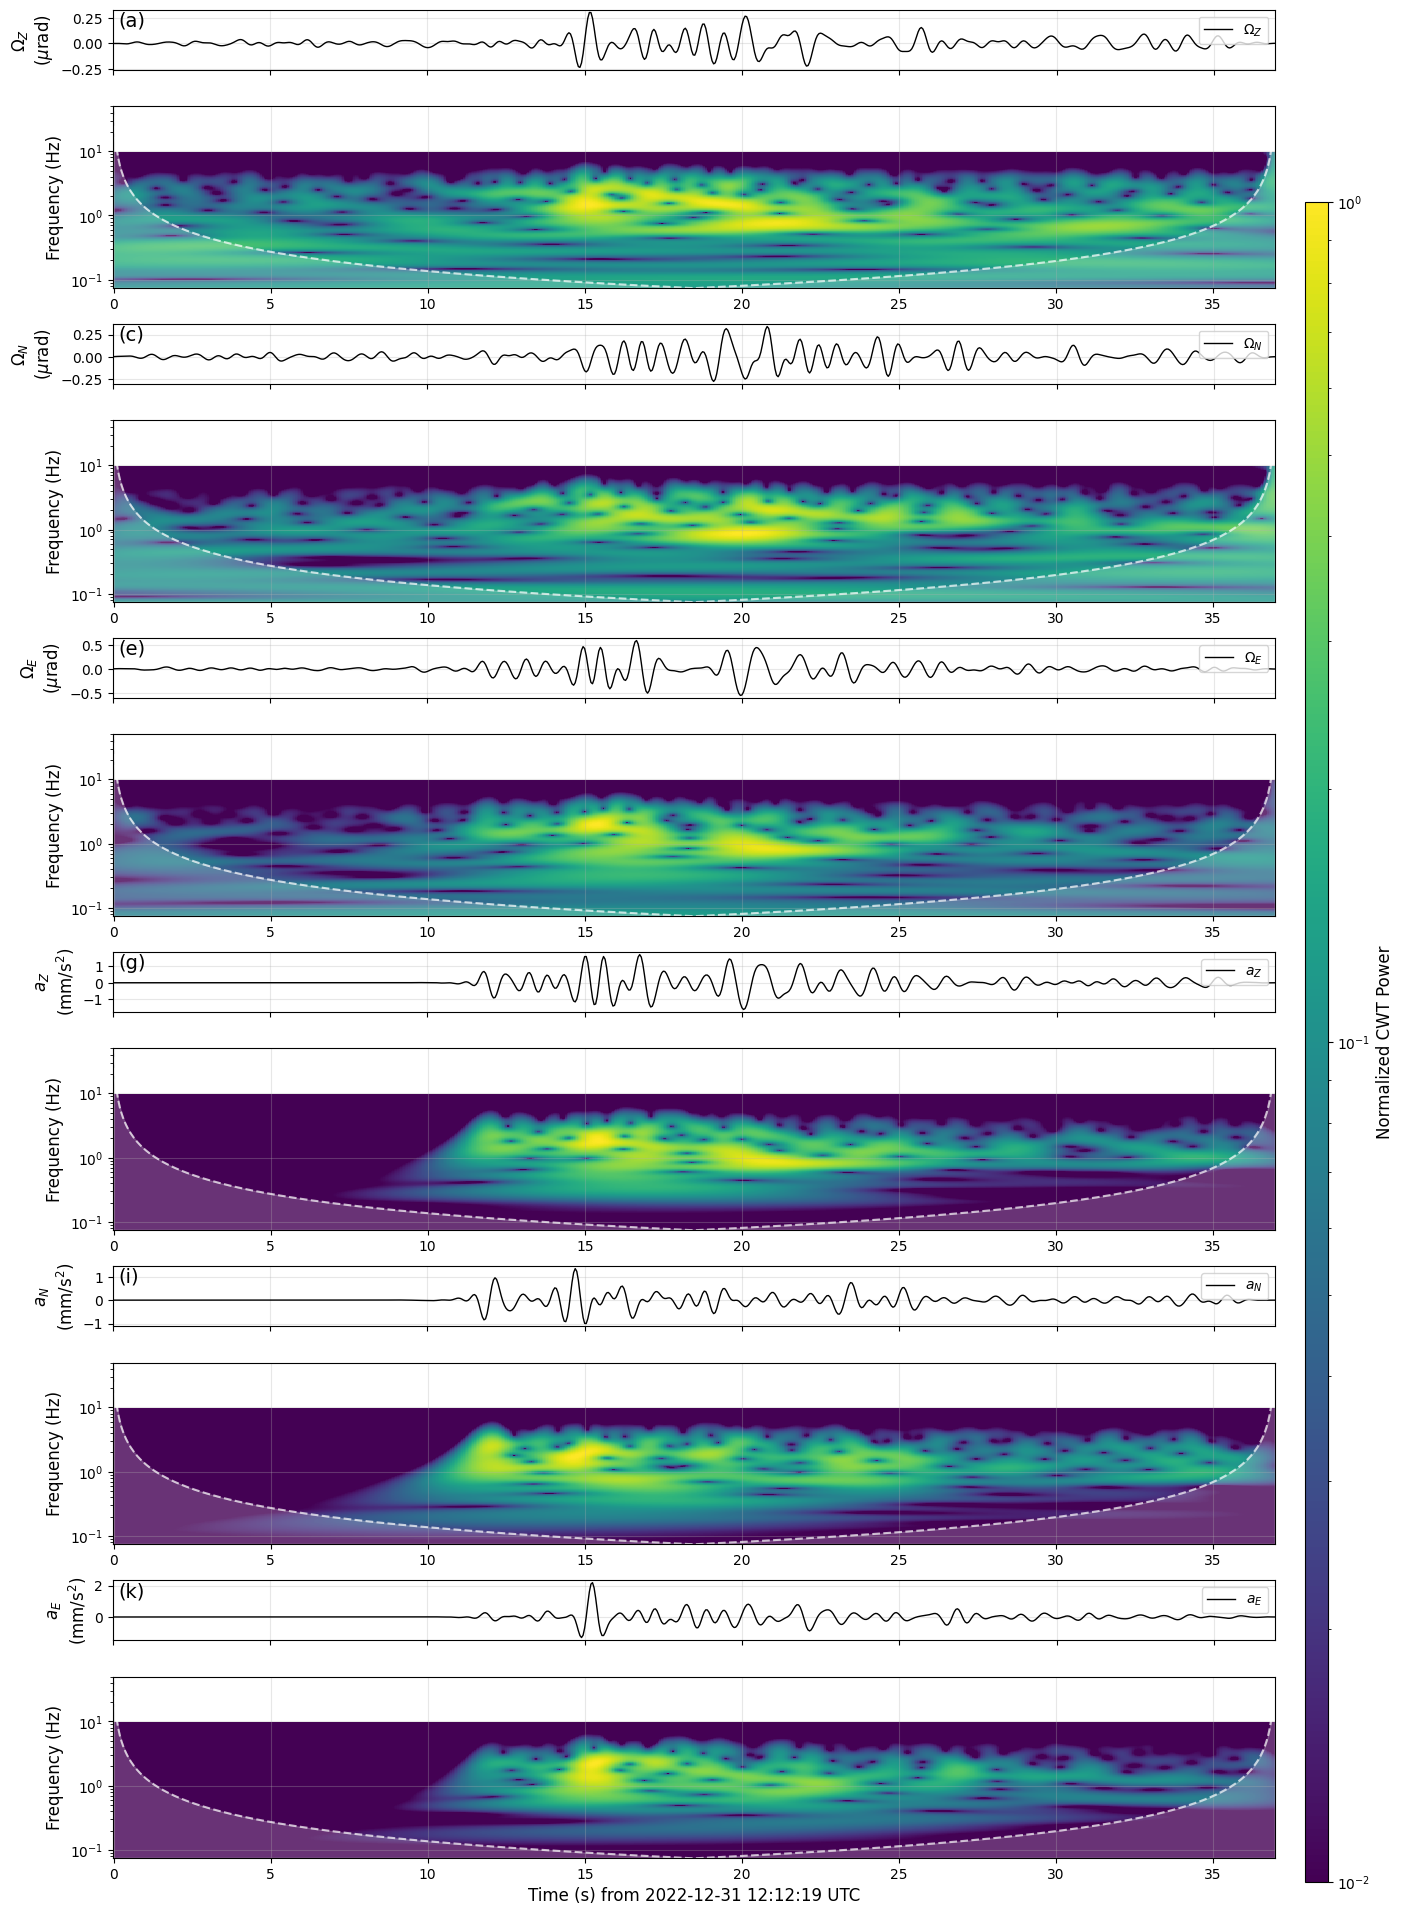

In [23]:
# First compute CWT for all components
cwt_results = {}
for comp in ['Z', 'N', 'E']:
    # Rotation components
    rot_data = sd.get_stream("rotation", raw=True).select(channel=f"*{comp}")[0]
    cwt_results[f"{rot_data.stats.channel}"] = sixdegrees.compute_cwt(
        rot_data.times(),
        rot_data.data,
        rot_data.stats.delta,
        normalize=True
    )
    
    # Translation components
    acc_data = sd.get_stream("translation", raw=True).select(channel=f"*{comp}")[0]
    cwt_results[f"{acc_data.stats.channel}"] = sixdegrees.compute_cwt(
        acc_data.times(), 
        acc_data.data,
        acc_data.stats.delta,
        normalize=True
    )

# Then plot all components
fig = plot_cwt_all(
    rot=sd.get_stream("rotation"),
    acc=sd.get_stream("translation"),
    cwt_output=cwt_results,
    clog=True,
    ylim=50
)

Frequency band to filter (this is applied to the stream object after being reset to raw stream)

In [24]:
sd.filter_data(fmin=params['fmin'], fmax=params['fmax'], output=False)

Apply polarity correction if needed. This is applied to the stream object that is processed. If raw is True, the polarity correction is applied to the raw stream too.

In [25]:
sd.polarity_stream(pol_dict={"HZ": -1, "JZ": 1}, raw=True)

-> polarity already applied. Exiting...


### Compare Waveforms

Let's compare the waveforms of the rotation (red) and translational (black) components. According to the theory both should be in phase for plane waves, thus the cross-correlation should be close to 1.

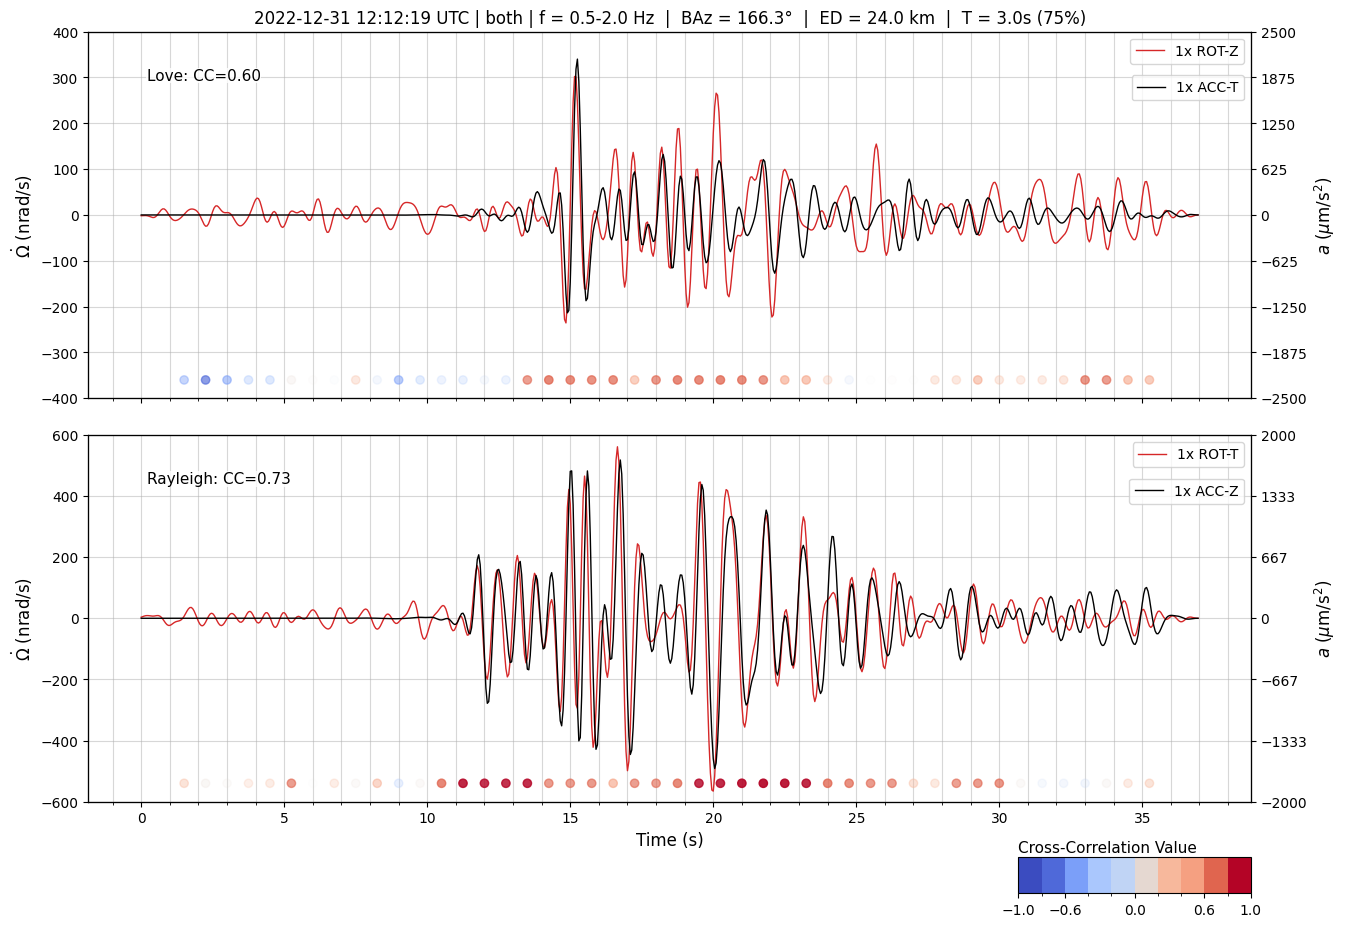

In [26]:
fig = plot_waveform_cc(
    sd_object=sd,
    twin_sec=params['twin_sec'],
    twin_overlap=params['twin_overlap'],
    wave_type="both"
)

Here we can compare the FFT spetra of the rotation and translational components.

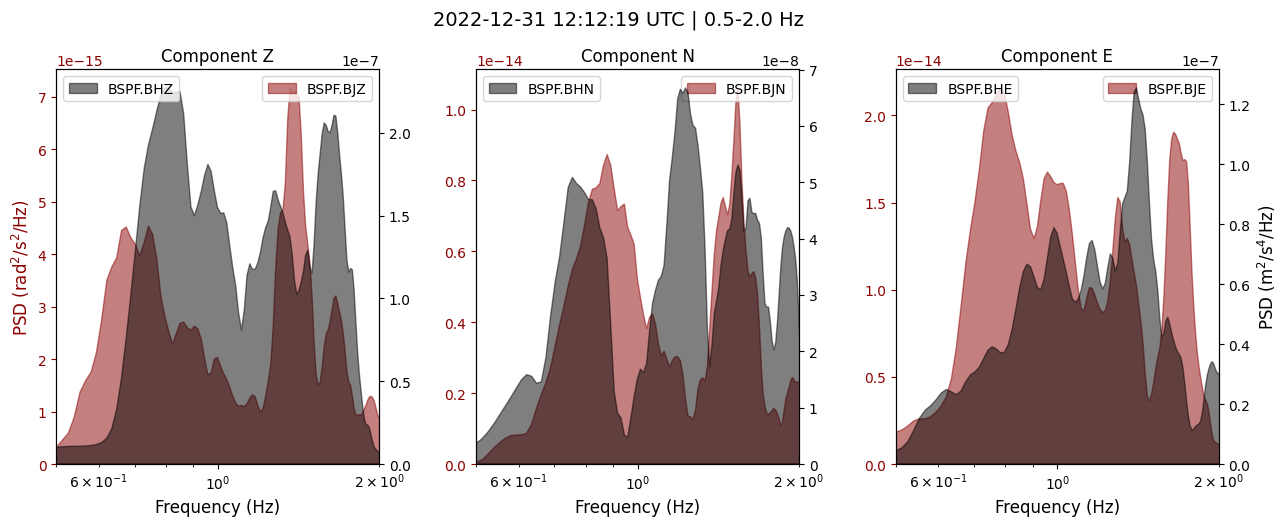

In [27]:
fig = plot_spectra_comparison_fill(
    sd_object=sd,
    ylog=False,
    xlog=True,
    fill=True
)

### Backazimuth Estimate

Now we want to estimate the backazimuth of the event. We can do this by computing the cross-correlation between the rotation and translational components (representing Love and Rayleigh waves, respectively) for different backazimuths.

baz_max = 193, baz_std = 30


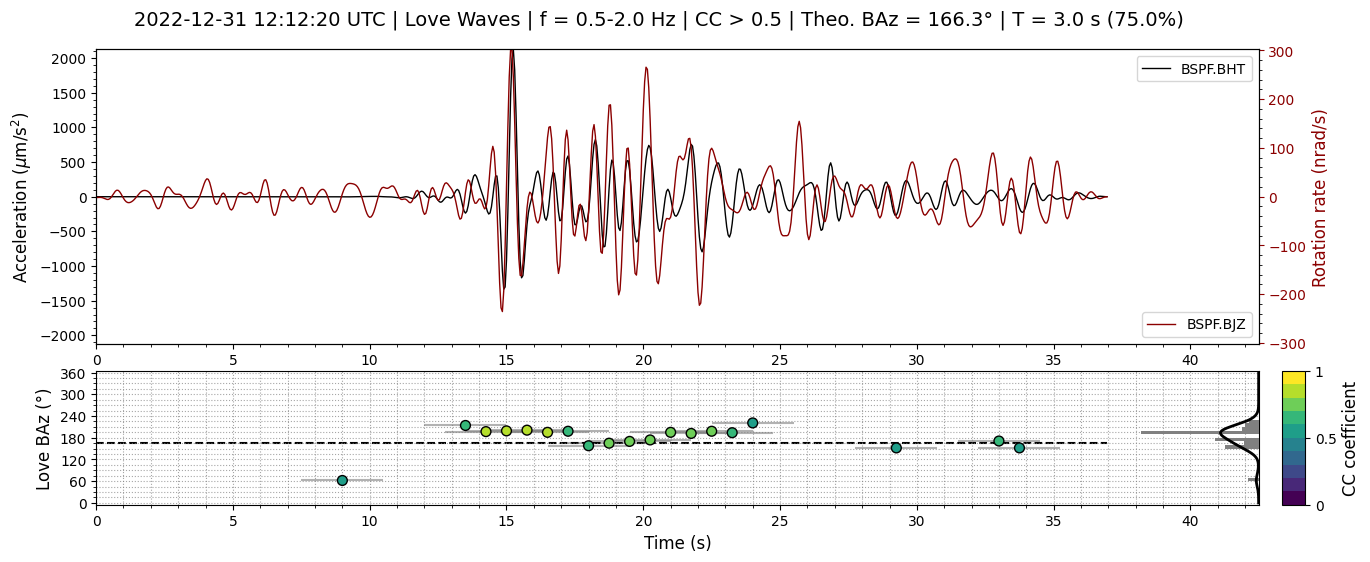

In [28]:
# First compute backazimuth
baz_results = sd.compute_backazimuth(
    wave_type='love',
    baz_step=params['baz_step'],
    baz_win_sec=params['twin_sec'],
    baz_win_overlap=params['twin_overlap'],
    out=True
)

# Then plot results
fig = plot_backazimuth_results(
    sd,
    baz_results,
    wave_type='love',
    baz_theo=ev['backazimuth'],
    cc_threshold=params['cc_threshold'],  # optional
)

baz_max = 156, baz_std = 29


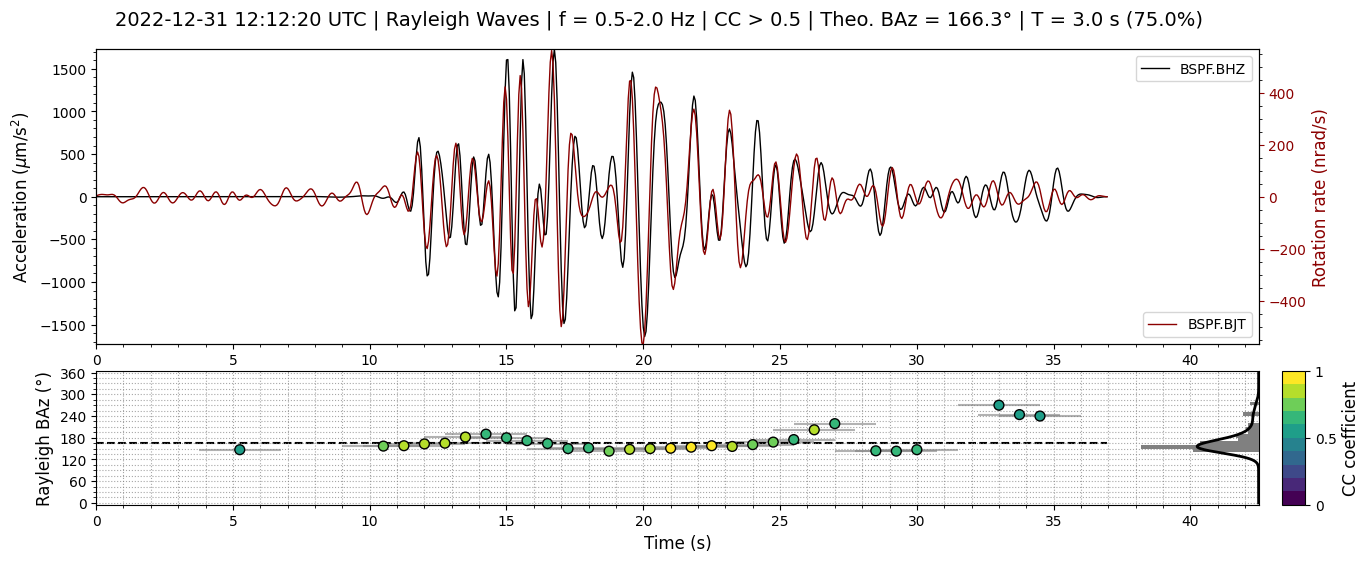

In [29]:
# First compute backazimuth
baz_results = sd.compute_backazimuth(
    wave_type='rayleigh',
    baz_step=params['baz_step'],
    baz_win_sec=params['twin_sec'],
    baz_win_overlap=params['twin_overlap'],
    out=True
)

# # Then plot results
fig = plot_backazimuth_results(
    sd,
    baz_results,
    wave_type='rayleigh',
    baz_theo=ev['backazimuth'],
    cc_threshold=params['cc_threshold'],  # optional
)

We can also compare the different backazimuth estimation methods. This also includes a method based on the horizontal rotation components (called tangent method). This is then compared to the theoretical backazimuth (based on the event location).

Using precomputed love backazimuth results

Estimated BAZ Love = 198° (CC ≥ 0.5)
Using precomputed rayleigh backazimuth results

Estimated BAZ Rayleigh = 137° (CC ≥ 0.5)
Using precomputed tangent backazimuth results

Estimated BAZ Tangent = 164° (CC ≥ 0.5)


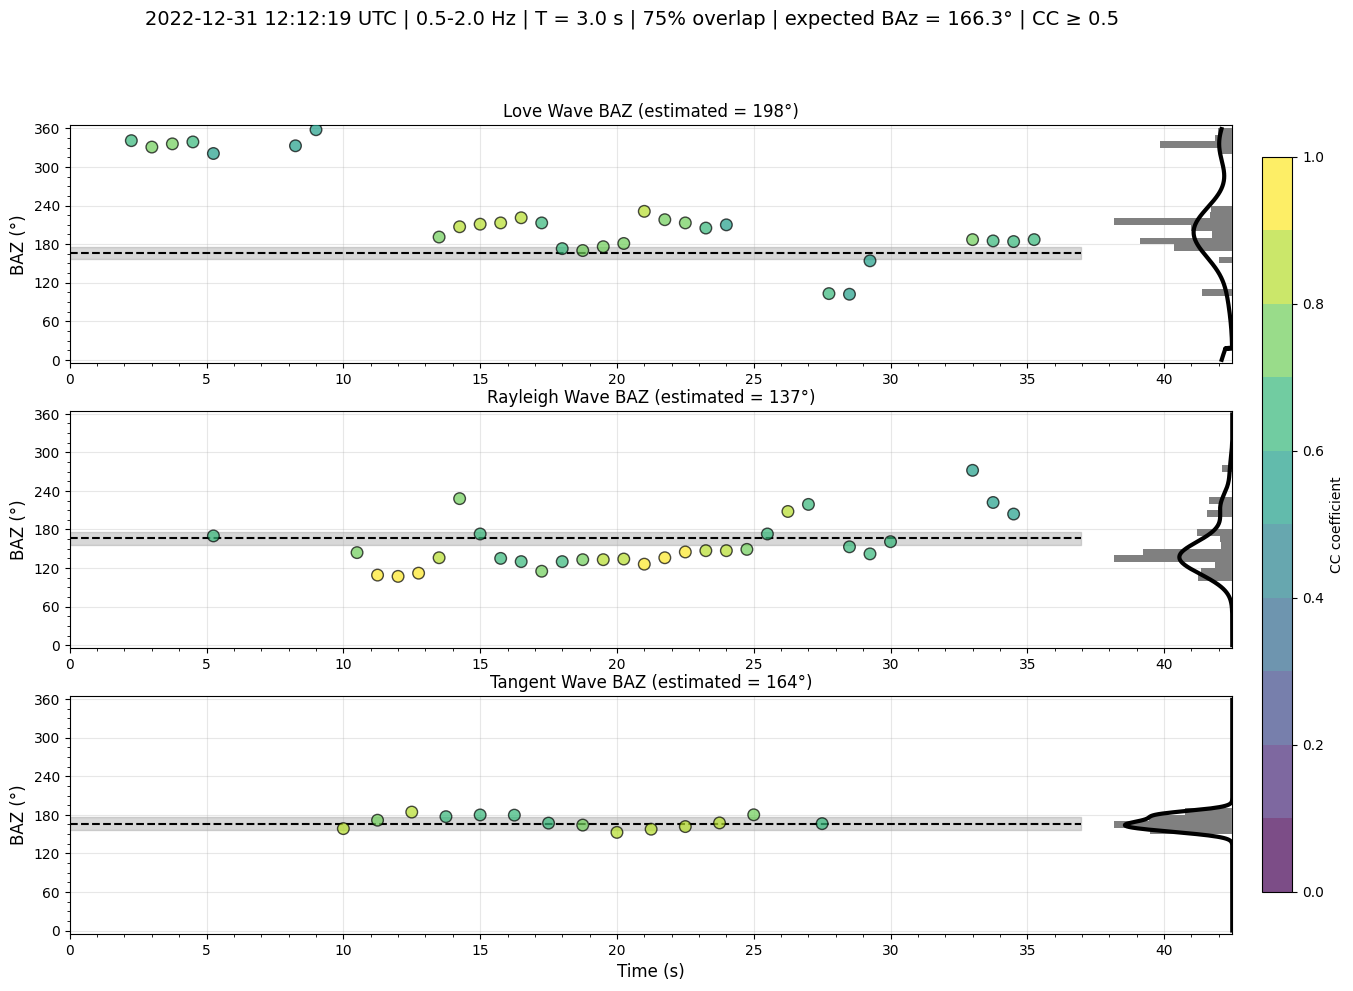

In [30]:
fig, results = sd.compare_backazimuth_methods(
    Twin=params['twin_sec'],
    Toverlap=params['twin_overlap'],
    cc_threshold=params['cc_threshold'],
    baz_theo=ev['backazimuth'],
    plot=True,
    output=True
)

### Analyse phase velocities

6 DoF observations allow us to estimate the phase velocities of Love and Rayleigh waves based on the amplitude ratios. For the estimation we use linear regression methods (ODR and RANSAC) to estimate the slope of rotational and translational amplitudes in time windows.


In [31]:
# Compute Love wave velocities
love_velocities = sd.compute_velocities(
    wave_type='love',
    win_time_s=params['twin_sec'],
    overlap=params['twin_overlap'],
    cc_threshold=params['cc_threshold'],
    method='odr',
    baz=ev['backazimuth']  # optional
)

# Compute Rayleigh wave velocities
rayleigh_velocities = sd.compute_velocities(
    wave_type='rayleigh',
    win_time_s=params['twin_sec'],
    overlap=params['twin_overlap'],
    cc_threshold=params['cc_threshold'],
    method='odr',
    baz=ev['backazimuth']  # optional
)

We can plot the results with the waveforms which are rotated using the theoretical backazimuth.

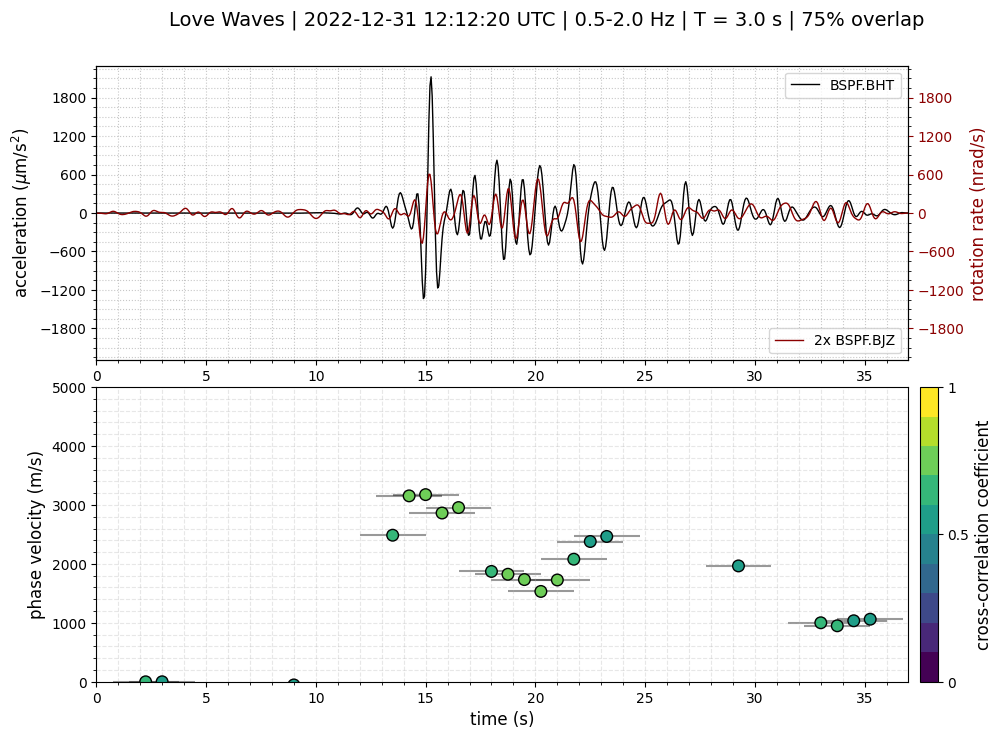

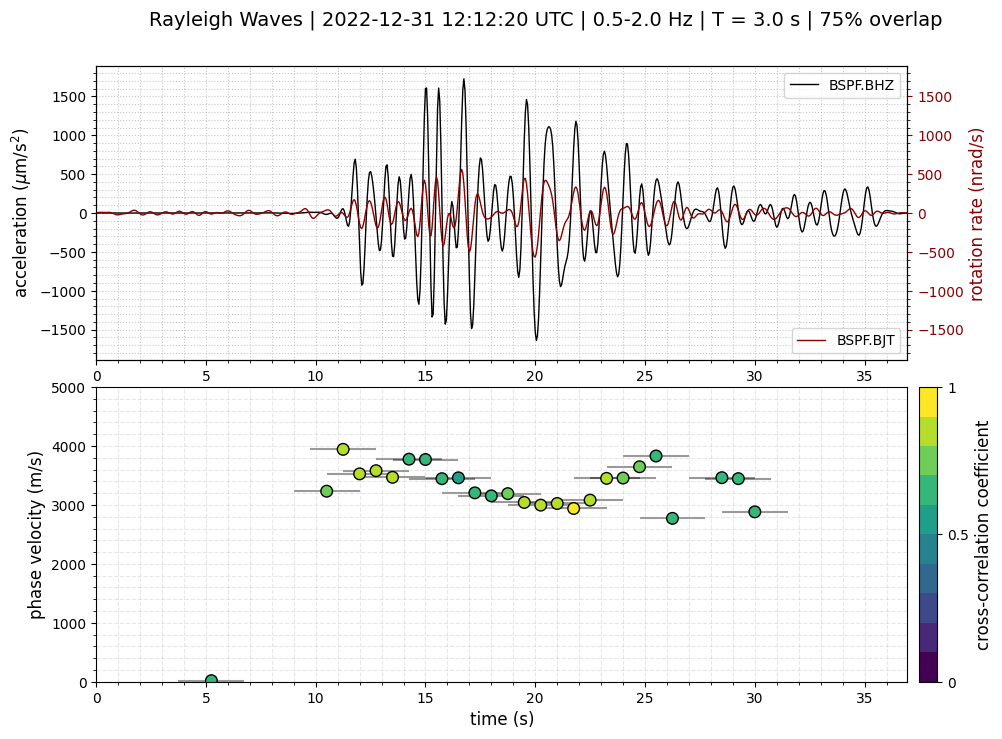

In [32]:
# Plot results
fig = plot_velocities(
    sd,
    velocity_results=love_velocities,
    vmax=5000,  # optional
    minors=True # optional
)

# Plot results
fig = plot_velocities(
    sd,
    velocity_results=rayleigh_velocities,
    vmax=5000,  # optional
    minors=True # optional
)

### Check Dispersion with Frequency

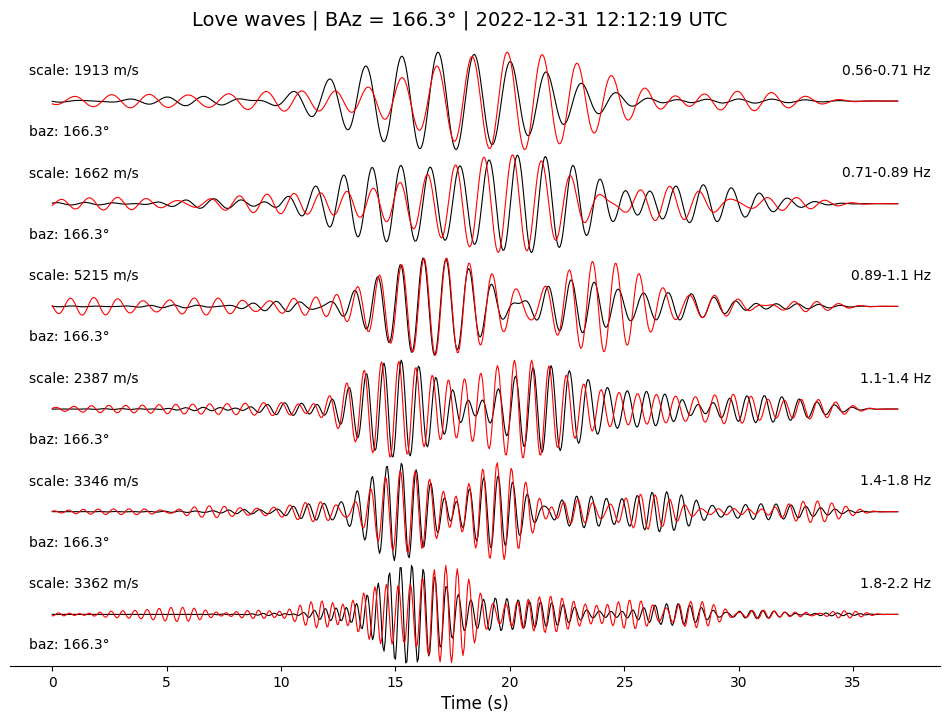

In [37]:
fig, disp_love = plot_trace_dispersion(
    sd_object=sd,
    wave_type="Love", # "love" | "rayleigh"
    fmin=0.7,
    fmax=2.0,
    fraction_of_octave=3,
    figsize=(12, 8),
    output=True, # output results
    optimized=False # find an optimized backazimuth
)
